# Assignment: Linear regression on the Advertising data

*Fraida Fund*

Fill in your name and net ID:

-   **Name**: Yiheng Zhou
-   **net ID**:yz11306

Make a copy of this notebook in your own Google Drive and, as you work through it, fill in missing code and answers to the questions.

After you are finished, you will copy your answers from individual sections *and* a copy of the entire notebook into PrairieLearn for submission. (Note that the PrairieLearn autograder will expect that you have used exactly the variable names shown in this template notebook.)

Answers to open-ended questions (e.g. “Comment on the results..”) must be **in your own words**, reflecting your own interpretation and understanding, and must refer to specific results (including numeric values) you obtained in this notebook.

To illustrate principles of linear regression, we are going to use some data from the textbook “An Introduction to Statistical Learning with Applications in R/Python” (Gareth James, Daniela Witten, Trevor Hastie, Robert Tibshirani).

The dataset is described as follows:

> Suppose that we are statistical consultants hired by a client to provide advice on how to improve sales of a particular product. The `Advertising` data set consists of the sales of that product in 200 different markets, along with advertising budgets for the product in each of those markets for three different media: TV, radio, and newspaper.
>
> …
>
> It is not possible for our client to directly increase sales of the product. On the other hand, they can control the advertising expenditure in each of the three media. Therefore, if we determine that there is an association between advertising and sales, then we can instruct our client to adjust advertising budgets, thereby indirectly increasing sales. In other words, our goal is to develop an accurate model that can be used to predict sales on the basis of the three media budgets.

Sales are reported in thousands of units, and TV, radio, and newspaper budgets, are reported in thousands of dollars.

For this assignment, you will fit a linear regression model to a small dataset. You will iteratively improve your linear regression model by examining the residuals at each stage, in order to identify problems with the model.

In [2]:
from sklearn import metrics
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
sns.set()

### 0. Read in and pre-process data

In this section, you will read in the “Advertising” data, and make sure it is loaded correctly. Then, split the data into training data (70%) and test data (30%). We will use *only* the training data in our visualizations, etc.

Visually inspect the data using a pairplot, and note any meaningful observations. In particular, comment on which features appear to be correlated with product sales, and which features appear to be correlated with one another.

**The code in this section is provided for you**.

#### Read in data

In [3]:
!wget 'https://www.statlearning.com/s/Advertising.csv' -O 'Advertising.csv'

--2025-02-06 19:43:49--  https://www.statlearning.com/s/Advertising.csv
Resolving www.statlearning.com (www.statlearning.com)... 198.185.159.144, 198.49.23.145, 198.185.159.145, ...
Connecting to www.statlearning.com (www.statlearning.com)|198.185.159.144|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://static1.squarespace.com/static/5ff2adbe3fe4fe33db902812/t/5fffe03b4091076ff5b30c72/1610604603901/Advertising.csv [following]
--2025-02-06 19:43:49--  https://static1.squarespace.com/static/5ff2adbe3fe4fe33db902812/t/5fffe03b4091076ff5b30c72/1610604603901/Advertising.csv
Resolving static1.squarespace.com (static1.squarespace.com)... 151.101.0.238, 151.101.64.238, 151.101.128.238, ...
Connecting to static1.squarespace.com (static1.squarespace.com)|151.101.0.238|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4555 (4.4K) [text/csv]
Saving to: ‘Advertising.csv’

Advertising.csv     100%[===================>]   4.45K  --.-KB/s  

In [4]:
df  = pd.read_csv('Advertising.csv', index_col=0)
df.head()

,TV,radio,newspaper,sales
1,230.1,37.8,69.2,22.1
2,44.5,39.3,45.1,10.4
3,17.2,45.9,69.3,9.3
4,151.5,41.3,58.5,18.5
5,180.8,10.8,58.4,12.9


Note that in this dataset, the first column in the data file is the row label; that’s why we use `index_col=0` in the `read_csv` command. If we would omit that argument, then we would have an additional (unnamed) column in the dataset, containing the row number.

(You can try removing the `index_col` argument and re-running the cell above, to see the effect and to understand why we used this argument.)

#### Split up data

We will use 70% of the data for training and the remaining 30% as a held-out test set to evaluate the regression model on data *not* used for training.

In [5]:
train, test = train_test_split(df, test_size=0.3, random_state=9)

We set the `random_state` to a constant so that every time you run this notebook, exactly the same data points will be assigned to test vs. training sets. This is helpful in the debugging stage.

In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 140 entries, 134 to 127
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   TV         140 non-null    float64
 1   radio      140 non-null    float64
 2   newspaper  140 non-null    float64
 3   sales      140 non-null    float64
dtypes: float64(4)
memory usage: 5.5 KB


In [7]:
test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 60 entries, 85 to 7
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   TV         60 non-null     float64
 1   radio      60 non-null     float64
 2   newspaper  60 non-null     float64
 3   sales      60 non-null     float64
dtypes: float64(4)
memory usage: 2.3 KB


#### Visually inspect the data

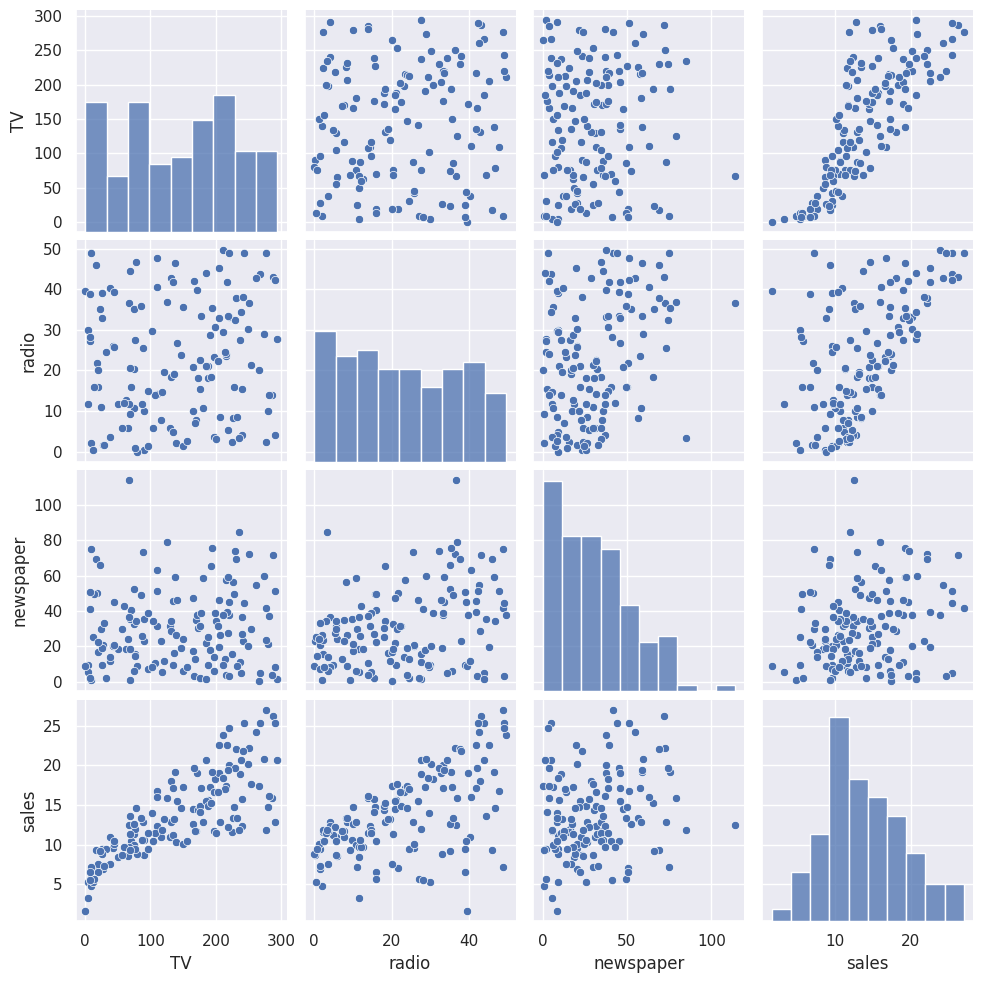

In [8]:
sns.pairplot(train);

The most important panels here are on the bottom row, where `sales` is on the vertical axis and the advertising budgets are on the horizontal axes.

Looking at this row, we may identify some features that appear to be useful predictive features for `sales`, but we cannot *rule out* any features based on this visualization.

**Comment on this plot**. What features appear to be related to the target variable? What features appear to be correlated with other features?

TV and radio are features that have a strong correlation with the target variable, sales, especially TV, which shows a significant linear relationship.
newspaper has little impact on sales and might be a weaker predictor.
There is no apparent correlation among the features (TV, radio, and newspaper), indicating that they may independently influence sales without introducing multicollinearity issues.

### 1. Fit simple linear regression models

Use the training data to fit a simple linear regression to predict product sales, for each of three features: TV ad budget, radio ad budget, and newspaper ad budget.

In other words, you will fit *three* regression models,

-   a `reg_tv` model that uses `tv` as a feature to predict `sales`
-   a `reg_radio` model that uses `radio` as a feature to predict `sales`
-   a `reg_news` model that uses `newspaper` as a feature to predict `sales`

#### Fit a simple linear regression

The code for the first model, `reg_tv`, is provided for you. Fill in `reg_radio` and `reg_news`.

In [9]:
#grade (write your code in this cell and DO NOT DELETE THIS LINE)

reg_tv    = LinearRegression().fit(train[['TV']], train['sales'])
# reg_radio = ...
# reg_news  = ...

reg_radio = LinearRegression().fit(train[['radio']], train['sales'])
reg_news = LinearRegression().fit(train[['newspaper']], train['sales'])

#### Look at coefficients

Look at the intercept $w_0$ and the slope coefficient $w_1$ of each model. The code for the first model, `reg_tv`, is provided for you.

In [10]:
print("TV       : ", reg_tv.coef_[0], reg_tv.intercept_)
# print("Radio    : ",  ??? )
# print("Newspaper: ",  ??? )

print("Radio    : ", reg_radio.coef_[0], reg_radio.intercept_)
print("Newspaper: ", reg_news.coef_[0], reg_news.intercept_)

TV       :  0.04964468781898984 6.711432632336138
Radio    :  0.21062312839115208 8.997640913704718
Newspaper:  0.046574464282301664 12.375549417451523


#### Plot data and regression line

The following cell will show a visualization of the training data and the regression model you fitted in each case.

Note that the range of the horizontal axis in each case is very different, because the upper end of the range of spending on TV ads is much larger than e.g. on radio ads. Therefore, you can’t judge the relative slope just by looking at the visualization - you will have to refer back to the slop coefficients you printed above.

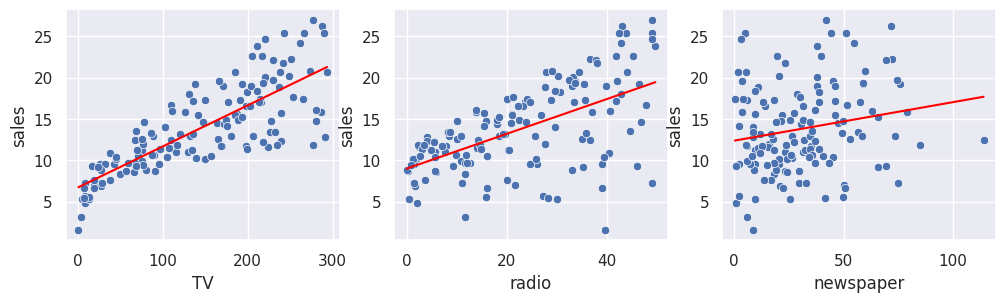

In [11]:
fig = plt.figure(figsize=(12,3))

plt.subplot(1,3,1)
sns.scatterplot(data=train, x="TV", y="sales");
sns.lineplot(data=train, x="TV", y=reg_tv.predict(train[['TV']]), color='red');

plt.subplot(1,3,2)
sns.scatterplot(data=train, x="radio", y="sales");
sns.lineplot(data=train, x="radio", y=reg_radio.predict(train[['radio']]), color='red');

plt.subplot(1,3,3)
sns.scatterplot(data=train, x="newspaper", y="sales");
sns.lineplot(data=train, x="newspaper", y=reg_news.predict(train[['newspaper']]), color='red');

#### Compute R2, MSE for simple regression

For each model, let’s get:

-   the predictions on the training set: `y_pred_tr_tv`, `y_pred_tr_radio`, `y_pred_tr_news`
-   the R2 score on the training set: `r2_tr_tv`, `r2_tr_radio`, `r2_tr_news`
-   the MSE on the training set: `mse_tr_tv`, `mse_tr_radio`, `mse_tr_news`

These are already provided for you, for the TV case.

In [12]:
#grade (write your code in this cell and DO NOT DELETE THIS LINE)

y_pred_tr_tv    = reg_tv.predict(train[['TV']])
# y_pred_tr_radio = ...
# y_pred_tr_news  = ...

y_pred_tr_radio = reg_radio.predict(train[['radio']])
y_pred_tr_news = reg_news.predict(train[['newspaper']])

In [13]:
#grade (write your code in this cell and DO NOT DELETE THIS LINE)

r2_tr_tv    = metrics.r2_score(train['sales'], y_pred_tr_tv)
# r2_tr_radio = ...
# r2_tr_news  = ...

r2_tr_radio = metrics.r2_score(train['sales'], y_pred_tr_radio)
r2_tr_news = metrics.r2_score(train['sales'], y_pred_tr_news)

In [14]:
print("TV       : ", r2_tr_tv)
# print("Radio    : ", r2_tr_radio)
# print("Newspaper: ", r2_tr_news)

print("Radio    : ", r2_tr_radio)
print("Newspaper: ", r2_tr_news)

TV       :  0.6462575775839753
Radio    :  0.33630082549935214
Newspaper:  0.0373981756207491


In [15]:
#grade (write your code in this cell and DO NOT DELETE THIS LINE)

mse_tr_tv    = metrics.mean_squared_error(train['sales'], y_pred_tr_tv)
# mse_tr_radio = ...
# mse_tr_news  = ...

mse_tr_radio = metrics.mean_squared_error(train['sales'], y_pred_tr_radio)
mse_tr_news = metrics.mean_squared_error(train['sales'], y_pred_tr_news)

In [16]:
print("TV       : ", mse_tr_tv)
# print("Radio    : ", mse_tr_radio)
# print("Newspaper: ", mse_tr_news)

print("Radio    : ", mse_tr_radio)
print("Newspaper: ", mse_tr_news)

TV       :  9.798510609335318
Radio    :  18.384177273212142
Newspaper:  26.663650133692155


### 2. Explore the residuals for the single linear regression models

Computing MSE or R2 is not sufficient to diagnose a problem with a linear regression.

In this section, you will create some additional visualizations of the training data as described below. to help you identify any problems with the regression.

#### Compute residuals

First, for each of the three regression models, you will compute the residuals ($y - \hat{y}$).

The code for the TV model is already provided for you.

In [17]:
#grade (write your code in this cell and DO NOT DELETE THIS LINE)

residual_tv_tr = train['sales'] - reg_tv.predict(train[['TV']])
# residual_news_tr = ...
# residual_radio_tr = ...

residual_radio_tr = train['sales'] - reg_radio.predict(train[['radio']])
residual_news_tr = train['sales'] - reg_news.predict(train[['newspaper']])

#### Plot predicted vs. actual sales

Next, you’ll create a plot of predicted sales vs. actual sales for each of the three models.

You will organize these as three *subplots* in one row. In each subplot, for a different model,

-   Create a scatter plot of predicted sales ($\hat{y}$) on the vertical axis, and actual sales ($y$) on the horizontal axis.
-   Make sure both axes use the same scale (the range of the vertical axis should be the same as the range of the horizontal axis) and that all three subplots use the same scale. Since the units of `sales` and predicted `sales` should be the same, if we use the same scale we can make direct comparisons based on the appearance of the plots.
-   Label each axes, and each plot.

Code is provided for you for the TV model - add subplots to the figure to also show the radio model and the newspaper model.

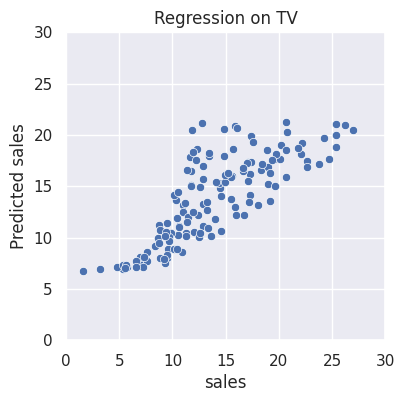

In [18]:

fig = plt.figure(figsize=(14,4))

plt.subplot(1,3,1)
sns.scatterplot(data=train, x="sales", y=reg_tv.predict(train[['TV']]));
plt.ylabel('Predicted sales');
plt.ylim(0,30);
plt.xlim(0,30);
plt.title("Regression on TV");


**Comment on this plot**. What would you expect this plot to look like for a model that explains the data well? What does the plot tell you about your models in this specific case?

The plot shows a positive correlation between predicted and actual sales, indicating the model captures the general trend.  However, the points deviate from the diagonal, especially at higher sales, suggesting the model's predictions are not perfect and may miss some variability in the data.

#### Plot residuals vs. actual sales

Next, you’ll create a plot of residuals vs. actual sales for each of the three models.

You will organize these as three *subplots* in one row. In each subplot, for a different model,

-   Create a scatter plot with the residuals ($y - \hat{y}$) on the vertical axis, and actual sales ($y$) on the horizontal axis.
-   Use the same vertical scale for all three subplots, and the same horizontal scale for all three subplots (but the vertical scale and the horizontal scale will not be the same as one another!).
-   Label each axes, and each plot.

Code is provided for you for the TV model - add subplots to the figure to also show the radio model and the newspaper model.

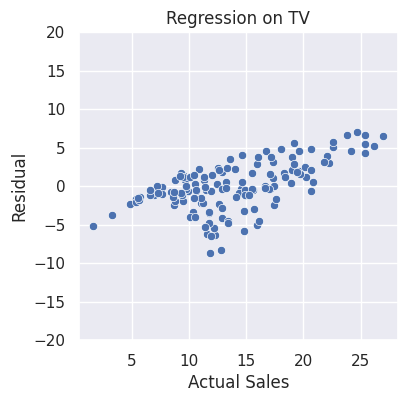

In [19]:

fig = plt.figure(figsize=(14,4))

plt.subplot(1,3,1)
sns.scatterplot(x=train['sales'], y=residual_tv_tr);
plt.xlabel('Actual Sales')
plt.ylabel('Residual');
plt.ylim(-20, 20)
plt.title("Regression on TV");


**Comment on this plot**. Is there a pattern in the residuals (and if so, what might it indicate), or do they appear to have no pattern with respect to actual sales?

There is a general positive correlation. The residual plot shows an upward trend in residuals at higher actual sales, indicating the model may underestimate at higher sales values. Ideally, residuals should be randomly distributed with no clear pattern.

#### Plot residuals vs. features

Finally, you’ll create a plot of residuals vs. features, for each combination of “model” and “feature” (9 subplots total).

In each column, for a different model,

-   create a scatter plot with the residuals ($y - \hat{y}$) on the vertical axis, and the feature ($x$) on the horizontal axis, for each feature.
-   Use the same vertical scale for all subplots (but the horizontal scale will depend on the feature! The upper end of the TV ad spending range is different from the radio ad spending range.)
-   Make sure to clearly label each axis, and also label each subplot with a title that indicates which regression model it uses.

Code is provided for you for the TV model - add subplots to the figure to also show the radio model and the newspaper model.

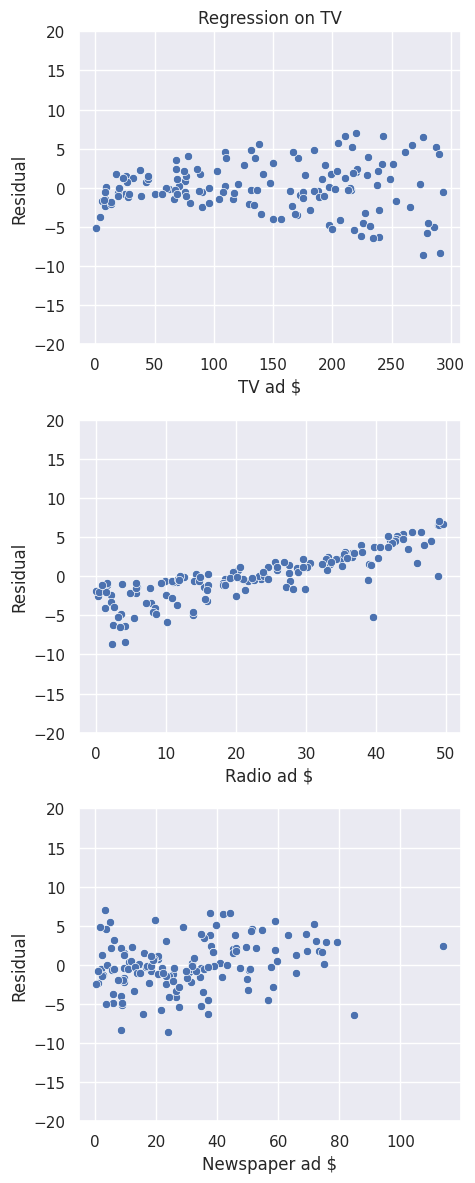

In [20]:

plt.figure(figsize=(13,12))

plt.subplot(3,3,1)
sns.scatterplot(x=train['TV'], y=residual_tv_tr);
plt.xlabel('TV ad $')
plt.ylabel('Residual');
plt.ylim(-20, 20);
plt.title("Regression on TV");

plt.subplot(3,3,4)
sns.scatterplot(x=train['radio'], y=residual_tv_tr);
plt.xlabel('Radio ad $')
plt.ylabel('Residual');
plt.ylim(-20, 20);

plt.subplot(3,3,7)
sns.scatterplot(x=train['newspaper'], y=residual_tv_tr);
plt.xlabel('Newspaper ad $')
plt.ylabel('Residual');
plt.ylim(-20, 20);

plt.tight_layout();

**Comment on this plot**. Is there a pattern in the residuals (and if so, what might it indicate), or do they appear to have no pattern with respect to each of the three features?

For the TV model, the residuals appear randomly distributed, indicating no clear pattern with respect to TV ad spending.
For the Radio model, residuals show an upward trend, suggesting the model may underestimate sales as radio ad spending increases.
For the Newspaper model, residuals appear fairly random, though some variability at higher ad spending might indicate inconsistencies in prediction accuracy.

### 3. Try a multiple linear regression

Next, you will fit a multiple linear regression to predict product sales, using all three features - TV ad budget, radio ad budget, and newspaper ad budget - to train *one* model.

The code to fit the model and look at the coefficients is provided for you.

#### Fit a multiple linear regression

In [21]:
#grade (write your code in this cell and DO NOT DELETE THIS LINE)

reg_multi = LinearRegression().fit(train[['TV', 'radio', 'newspaper']], train['sales'])

#### Look at coefficients

In [22]:
print("Coefficients (TV, radio, newspaper):", reg_multi.coef_)
print("Intercept: ", reg_multi.intercept_)

Coefficients (TV, radio, newspaper): [ 0.04636712  0.18249225 -0.00196151]
Intercept:  3.0762941463550604


#### Compute R2, MSE for multiple regression

Then, let’s get:

-   the predictions on the training set: `y_pred_tr_multi`
-   the R2 score on the training set: `r2_tr_multi`
-   the MSE on the training set: `mse_tr_multi`

In [24]:
#grade (write your code in this cell and DO NOT DELETE THIS LINE)
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
# y_pred_tr_multi = ...
# r2_tr_multi  = ...
# mse_tr_multi = ...
y_pred_tr_multi = reg_multi.predict(train[['TV', 'radio', 'newspaper']])


r2_tr_multi = r2_score(train['sales'], y_pred_tr_multi)
mse_tr_multi = mean_squared_error(train['sales'], y_pred_tr_multi)

In [25]:
# print("Multiple regression R2:  ", r2_tr_multi)
# print("Multiple regression MSE: ", mse_tr_multi)
print("Multiple regression R2:  ", r2_tr_multi)
print("Multiple regression MSE: ", mse_tr_multi)

Multiple regression R2:   0.8934006397815405
Multiple regression MSE:  2.952755722412376


#### Compute residuals

Compute the residuals ($y - \hat{y}$).

In [26]:
#grade (write your code in this cell and DO NOT DELETE THIS LINE)

# residual_multi_tr = ...
residual_multi_tr = train['sales'] - y_pred_tr_multi

#### Plot predicted vs. actual sales

Next, plot predicted sales vs. actual sales for the multiple regression model.

-   Create a scatter plot of predicted sales ($\hat{y}$) on the vertical axis, and actual sales ($y$) on the horizontal axis.
-   Make sure both axes use the same scale (the range of the vertical axis should be the same as the range of the horizontal axis).
-   Label each axes.

In [ ]:
# plot


**Comment on this plot**. What would you expect this plot to look like for a model that explains the data well? What does the plot tell you about your model in this specific case?

#### Plot residuals vs. actual sales

Next, create a plot of residuals vs. actual sales for the multiple regression model.

-   Create a scatter plot with the residuals ($y - \hat{y}$) on the vertical axis, and actual sales ($y$) on the horizontal axis.
-   Label each axes, and each plot.

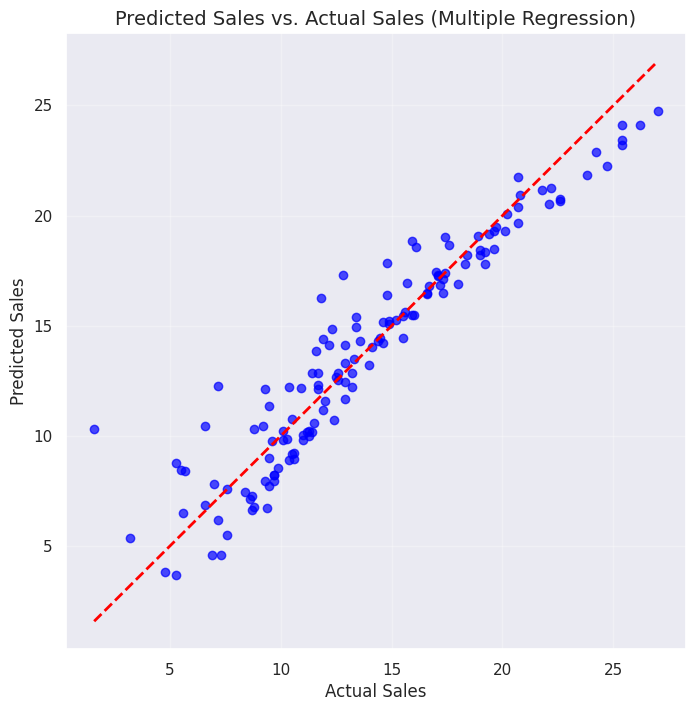

In [27]:
# plot
plt.figure(figsize=(8, 8))
plt.scatter(train['sales'], y_pred_tr_multi, alpha=0.7, color='blue')

plt.plot([train['sales'].min(), train['sales'].max()],
         [train['sales'].min(), train['sales'].max()],
         color='red', linestyle='--', linewidth=2)

plt.xlabel("Actual Sales", fontsize=12)
plt.ylabel("Predicted Sales", fontsize=12)
plt.title("Predicted Sales vs. Actual Sales (Multiple Regression)", fontsize=14)
plt.grid(alpha=0.3)
plt.show()

**Comment on this plot**. Is there a pattern in the residuals (and if so, what might it indicate), or do they appear to have no pattern with respect to actual sales?

The scatter plot shows that predicted sales align well with actual sales, with most points near the diagonal line. Residuals appear random, indicating no obvious bias. Minor deviations at the extremes suggest slight room for improvement but do not significantly affect the model's validity.

#### Plot residuals vs. features

Finally, you’ll create a plot of residuals vs. features, for each of the three features, for your multiple regression model. Put your three subplots in one row.

In each subplot,

-   create a scatter plot with the residuals ($y - \hat{y}$) on the vertical axis, and the feature ($x$) on the horizontal axis.
-   Use the same vertical scale for all subplots (but the horizontal scale will depend on the feature! The upper end of the TV ad spending range is different from the radio ad spending range.)
-   Make sure to clearly label each axis, and also label each subplot with a title that indicates which regression model it uses.

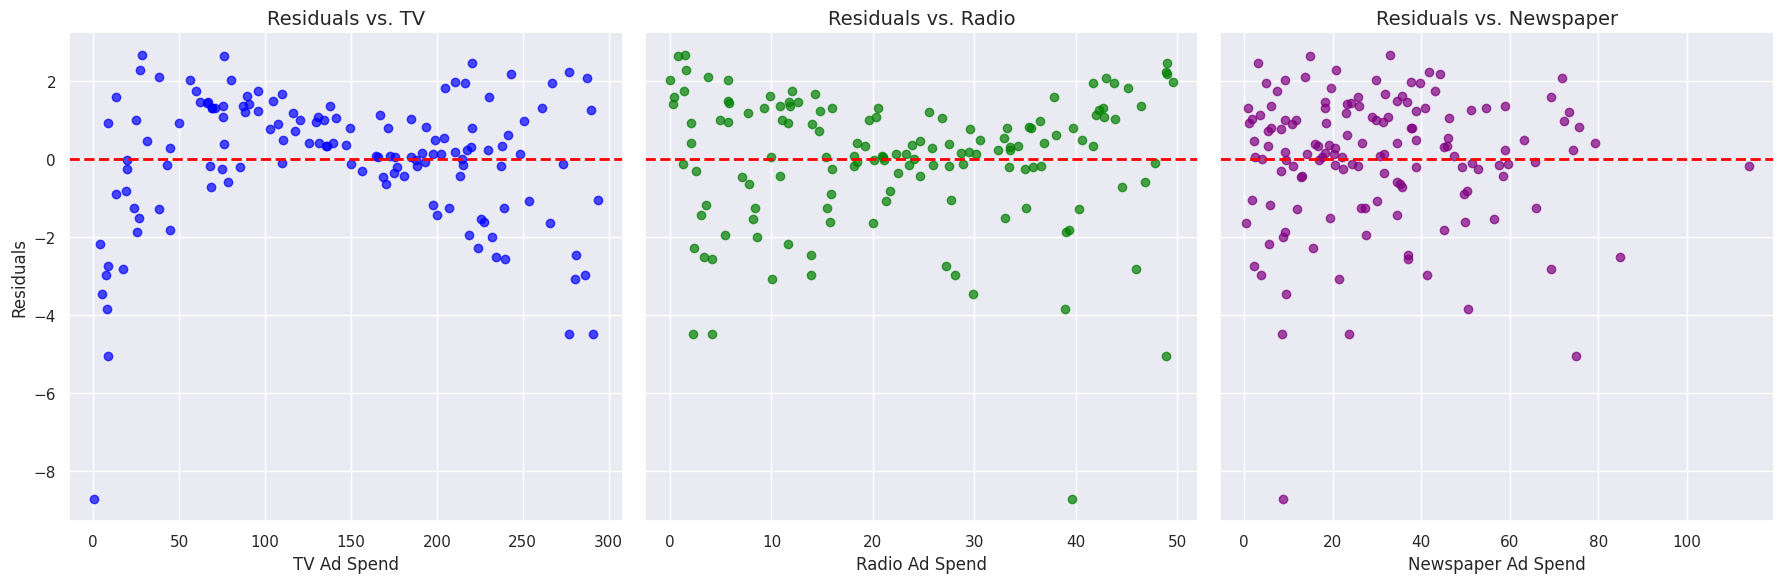

In [28]:
# plot


residuals = train['sales'] - y_pred_tr_multi

fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

#TV
axes[0].scatter(train['TV'], residuals, alpha=0.7, color='blue')
axes[0].axhline(0, color='red', linestyle='--', linewidth=2)  # 添加水平线 y=0
axes[0].set_xlabel('TV Ad Spend', fontsize=12)
axes[0].set_ylabel('Residuals', fontsize=12)
axes[0].set_title('Residuals vs. TV', fontsize=14)

#Radio
axes[1].scatter(train['radio'], residuals, alpha=0.7, color='green')
axes[1].axhline(0, color='red', linestyle='--', linewidth=2)  # 添加水平线 y=0
axes[1].set_xlabel('Radio Ad Spend', fontsize=12)
axes[1].set_title('Residuals vs. Radio', fontsize=14)

# Newspaper
axes[2].scatter(train['newspaper'], residuals, alpha=0.7, color='purple')
axes[2].axhline(0, color='red', linestyle='--', linewidth=2)  # 添加水平线 y=0
axes[2].set_xlabel('Newspaper Ad Spend', fontsize=12)
axes[2].set_title('Residuals vs. Newspaper', fontsize=14)

# display
plt.tight_layout()
plt.show()

**Comment on this plot**. Is there a pattern in the residuals (and if so, what might it indicate), or do they appear to have no pattern with respect to each of the three features?

Residuals vs. TV: No clear pattern, residuals are random.
Residuals vs. Radio: No pattern, residuals are random.
Residuals vs. Newspaper: Slightly more spread, but no strong pattern.

 Residuals show no significant patterns, so the model fits the data well.

### 4. Decomposing the multiple regression with FWL

In the previous section, you may have noticed that the coefficient for a given feature - say, newspaper - is different

-   in the simple linear regression on newspaper
-   and in the multiple regression which includes newspaper as well as other features.

In particular, in the simple linear regression we estimated that newspaper ad spending was associated with a positive effect on sales, similar in magnitude to TV ad spending. Now, the newspaper ads are estimated as having an association much closer to zero.

This is because:

-   In the simple regression case, the coefficent for newspaper ads represents the effect of an increase in newspaper advertising.
-   In the multiple regression case, the coefficient for newspaper ads represents the effect of an increase in newspaper advertising **while holding TV and radio advertising constant**.

It turns out that in the simple linear regression on newspaper ad budget, the regression was “learning” the effect of a feature that was correlated with newspaper ad budget, not the effect of newspaper ad budget itself. We observe that there is a correlation between newspaper ad budget and radio ad budget, and a smaller correlation between newspaper ad budget and TV ad budget. (This is logical; if an ad campaign spends a lot of money on one medium, they are likely to spend a lot on others as well.)

You can see this pairwise correlation in the following table.

In [29]:
train[['TV', 'radio', 'newspaper']].corr()

,TV,radio,newspaper
TV,1.000000,0.106568,0.057997
radio,0.106568,1.000000,0.314422
newspaper,0.057997,0.314422,1.000000


In this section, we will explore this further using the Frisch-Waugh-Lovell (FWL) theorem. This theorem will help us understand in greater depth what the coefficient in the multiple regression represents, when there are correlated features included in the regression.

#### Background: Frisch-Waugh-Lovell (FWL) theorem

Suppose we have a linear model with $k$ features:

$$\hat{y} = w_0 + w_1 x_1 + \ldots + w_k x_k + e$$

and residual $e = y - \hat{y}$, which is the part of $y$ that is not explained by the regression model.

The FWL theorem tells us that we can get $w_j$, the association between $x_j$ and $y$ *while holding other features constant*, with the following procedure to split up our multiple linear regression into *orthogonal* components - having no correlation.

##### Step 1

First, we will split the feature $x_j$ into (1) the information that is already present in other features, and (2) the information that is not already in other features.

How do you split the feature $x_j$ into parts that are correlated and uncorrelated with other features? With another regression model! We will train a model using all features *expect* $x_j$ to *predict* $x_j$, like this:

$$\hat{x_j} = w_0^{x_j} + \sum_{k \neq j} w^{x_{j}}_{k}x_{k}$$

where

-   the superscript $x_j$ on the coefficients denotes that these are the coefficients for the model to predict $x_j$
-   $\hat{x_j}$ is the estimate of $x_j$ according to this model, and this is the part of $x_j$ whose information is already in the other features
-   the residual of this model, $\epsilon^{x_{j}} = x_j - \hat{x_j}$, is the part of $x_j$ whose information is *not* already in the other features.

##### Step 2

Then, we’ll split the target variable $y$ into (1) the part that can be predicted using the other features *without* $x_j$, and (2) the part that cannot be predicted without $x_j$. Of course, we will do this in a similar way, with another regression model:

$$\hat{y} = w_0^{y} + \sum_{k \neq j} w^{y}_{k}x_{k}$$

where

-   the superscript $y$ on the coefficients denotes that these are the coefficients for the model to predict $y$, but without $x_j$
-   the residual of this model, $\epsilon^{y} = y - \hat{y}$, is the part of $y$ that cannot be predicted without $x_j$.

##### Step 3

This is the really interesting part! The FWL tells us that we can now train a model to:

-   predict $\epsilon^y$, the part of $y$ that is *not* predicted by the regression on features excluding $x_j$
-   as a simple regression on feature $\epsilon^{x_j}$, the part of $x_j$ that is *not* already “in” the other features

$$\epsilon^{y} = {w}^{*}_{j}\epsilon^{x_j} + \epsilon^{*}$$

and that

-   the coefficient $w^{*}_{j}$ - which tells us the association between “the parts of $x_j$ not in the other features” and “the parts of $y$ not predicted by the other features” - is going to be the **same** as $w_j$ in the multiple regression model we fitted earlier!
-   and the residuals $\epsilon^{*}$ will be the same as the residuals of the multiple regression model we fitted earlier.

#### Apply FWL to the “newspaper” feature

Let us try it now on the `newspaper` feature. We noticed earlier that `newspaper` had a large positive coefficient in the simple regression model, but not in the multiple regression model. We also noticed that newspaper ad spending was strongly correlated with radio ad spending.

Note: we will use the training data *only* throughout this section.

##### Step 1

First, use the *other* features (`TV` and `radio`) to train a model `reg_news_x` to “predict” `newspaper`.

-   The prediction of the model tells us: how much of the “signal” in the `newspaper` feature is already present in the other features?
-   The residual of the model tells us: how much of the “signal” in the `newspaper` feature is *not* present in the other features? The “model” cannot predict this part of `newspaper` using the `TV` and `radio` features.

Save the model prediction on the training data in `xhat_news_x` and the residual for the training data in `residual_news_x`.

In [30]:
#grade (write your code in this cell and DO NOT DELETE THIS LINE)

# reg_news_x  ...
# xhat_news_x = ...
# residual_news_x = ...

reg_news_x = LinearRegression()
reg_news_x.fit(train[['TV', 'radio']], train['newspaper'])

# Prediction of newspaper using TV and radio
xhat_news_x = reg_news_x.predict(train[['TV', 'radio']])

# Residual of newspaper, which is the part not explained by TV and radio
residual_news_x = train['newspaper'] - xhat_news_x

We can see that the residual is the part of `newspaper` that is uncorrelated with `radio` and `TV`.

In [31]:
pd.concat([train['TV'], train['radio'], pd.Series(residual_news_x, name='residual')], axis=1).corr()

,TV,radio,residual
TV,1.000000e+00,1.065683e-01,-7.902794e-17
radio,1.065683e-01,1.000000e+00,-1.925348e-16
residual,-7.902794e-17,-1.925348e-16,1.000000e+00


while the prediction of that “model” is, of course, correlated with the features used for prediction - it is a linear combination of those features. (The pairwise correlation is not ideal for measuring this, since $w_j x_j$ appears as noise with respect to an uncorrelated feature $x_k$, but we can get some idea.)

In [32]:
pd.concat([train['TV'], train['radio'], pd.Series(xhat_news_x, name='prediction')], axis=1).corr()

,TV,radio,prediction
TV,1.000000,0.106568,0.119602
radio,0.106568,1.000000,-0.120408
prediction,0.119602,-0.120408,1.000000


You can think of these two “components” of the “newspaper” feature as:

-   the part of the “newspaper” feature that reflects spending specifically on the newspaper medium. (the residual)
-   and the part that reflects the “spendiness” of the ad campaign, which is also reflected in TV and radio. (the prediction)

Let’s visualize these relationships. In the next cell, we will create a 2x2 grid of subplots:

-   On the top row, we use seaborn’s `regplot` to put `xhat_news_x` feature on the vertical axis, and the `TV` and `radio` features, respectively, on the horizontal axis. The `regplot` is a scatter plot with a simple linear regression line overlaid on top, to make it easier to see an association. Note that the horizontal scale of each subplot will be different, since the range of spending on TV ads is not the same as the range of spending on radio ads.
-   On the bottom row, we will do the same, but with `residual_news_x` on the vertical axis.

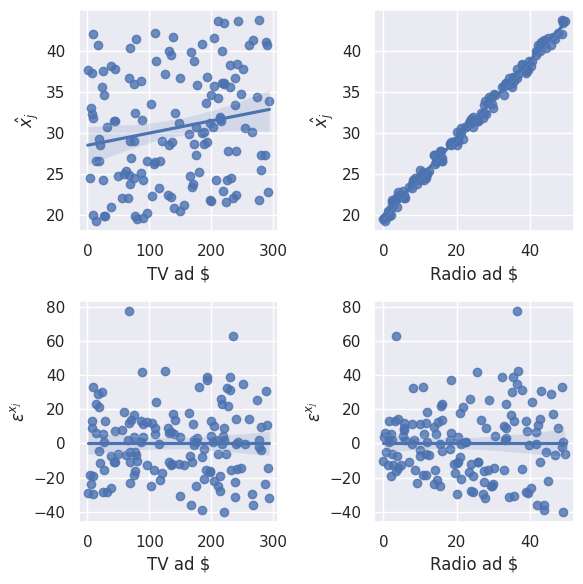

In [33]:
plt.figure(figsize=(6,6))

plt.subplot(2,2,1)
sns.regplot(x=train['TV'], y=xhat_news_x);
plt.xlabel('TV ad $')
plt.ylabel('$\hat{x_j}$');


plt.subplot(2,2,2)
sns.regplot(x=train['radio'], y=xhat_news_x);
plt.xlabel('Radio ad $')
plt.ylabel('$\hat{x_j}$');

plt.subplot(2,2,3)
sns.regplot(x=train['TV'], y=residual_news_x);
plt.xlabel('TV ad $')
plt.ylabel('$\epsilon^{x_j}$');

plt.subplot(2,2,4)
sns.regplot(x=train['radio'], y=residual_news_x);
plt.xlabel('Radio ad $')
plt.ylabel('$\epsilon^{x_j}$');

plt.tight_layout();

**Comment on the results**. What do you notice about the relationship between $\hat{x_{j}}$ and the other features, vs the relationship between $\epsilon^{x_{j}}$ and the other features? (Note: when you judge the relative slope of the line in these plots, don’t forget to be mindful of the different horizontal scales of your plots!)

x_j: Strong relationship with radio (clear linear correlation since they are highly related).
Weak relationship with TV (almost no correlation).

epsilon^(x_j): No relationship with radio or TV (residuals are random, and regression lines are nearly flat).

##### Step 2

Now, train a model `reg_news_y` to predict “sales” *without* `newspaper`, using only `TV` and `radio` features. Save the prediction of this model on the training data in `yhat_news_y`, and the residuals of this model for the training data in `residual_news_y`.

In [34]:
#grade (write your code in this cell and DO NOT DELETE THIS LINE)

# reg_news_y  = ...
# yhat_news_y = ...
# residual_news_y = ...

# Train a model using only TV and radio features
reg_news_y = LinearRegression()
reg_news_y.fit(train[['TV', 'radio']], train['sales'])

yhat_news_y = reg_news_y.predict(train[['TV', 'radio']])

# Calculate the residuals
residual_news_y = train['sales'] - yhat_news_y

and, we’ll use this to generate a similar plot -

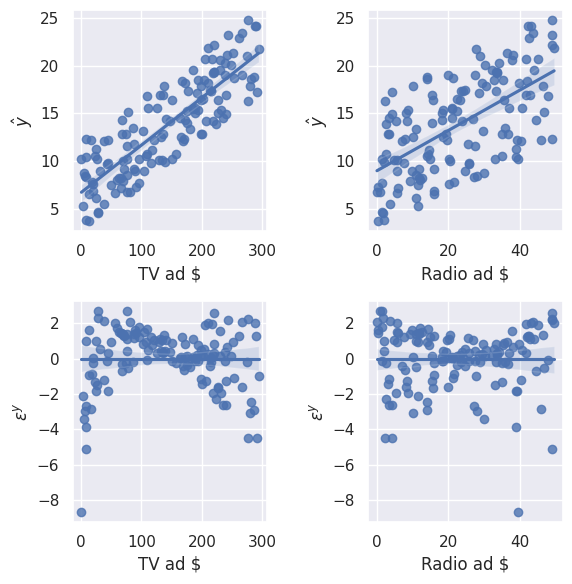

In [35]:
plt.figure(figsize=(6,6))

plt.subplot(2,2,1)
sns.regplot(x=train['TV'], y=yhat_news_y);
plt.xlabel('TV ad $')
plt.ylabel('$\hat{y}$');


plt.subplot(2,2,2)
sns.regplot(x=train['radio'], y=yhat_news_y);
plt.xlabel('Radio ad $')
plt.ylabel('$\hat{y}$');

plt.subplot(2,2,3)
sns.regplot(x=train['TV'], y=residual_news_y);
plt.xlabel('TV ad $')
plt.ylabel('$\epsilon^{y}$');

plt.subplot(2,2,4)
sns.regplot(x=train['radio'], y=residual_news_y);
plt.xlabel('Radio ad $')
plt.ylabel('$\epsilon^{y}$');

plt.tight_layout();

Once again, you can think of these two “components” of `sales` as:

-   the part of `sales` that is not predicted by the model on `TV` and `radio`. (the residual)
-   and the part that *is* predicted by the model on `TV` and `radio`. (the prediction)

**Comment on the results**. What do you notice about the relationship between $\hat{y}$ and the other (not-$x_j$) features, vs the relationship between $\epsilon^{y}$ and the other features?

y and features(TV, radio): Strong positive relationship with TV and radio (top plots).

Residuals epsilon^y and features(TV,radio): No relationship; residuals are random (bottom plots).

##### Step 3

Finally, train a model `reg_news_fwl` on the residuals of the other two models! In this linear regression,

-   the feature is `residual_news_x`
-   the target variable is `residual_news_y`
-   you will set `fit_intercept = False` - there is no $w_0$, since both feature and target variable are already zero-mean.

Save the predictions on the training set in `yhat_news_fwl`, and the residual in `residual_news_fwl`.

In [36]:
#grade (write your code in this cell and DO NOT DELETE THIS LINE)

# reg_news_fwl  = ...
# yhat_news_fwl = ...
# residual_news_fwl = ...

reg_news_fwl = LinearRegression(fit_intercept=False)
reg_news_fwl.fit(residual_news_x.values.reshape(-1, 1), residual_news_y)

# Save the predictions
yhat_news_fwl = reg_news_fwl.predict(residual_news_x.values.reshape(-1, 1))

residual_news_fwl = residual_news_y - yhat_news_fwl

Check the coefficient of this model -

In [37]:
reg_news_fwl.coef_

array([-0.00196151])

and compare it to the coefficient for `newspaper` in the simple regression `reg_news`, and in the multiple regression `reg_multi`.

You can see that

-   the association between “the part of `newspaper` *not* in `radio` or `TV`” and “the part of `sales` *not* predicted by `radio` or `TV`” (from this “residualized” model)
-   is exactly the same as “the association between `newspaper` and `sales` when `radio` and `TV` are held constant” (from the multiple regression model fitted in the previous section).

Furthermore, this “residualized” model helps us understand that part of `residual_news_y` is “explained” by “the part of `newspaper` *not* in `radio` or `TV`”, and part is not.

We can see this more clearly in the following plot, which shows:

-   `sales` vs `newspaper` with the regression line showing the effect of `newspaper`, according to the regression on `newspaper` alone.
-   `sales` vs `newspaper` with the regression line showing the effect of `newspaper`, according to the multiple regression model.
-   and the “residualized” `sales` vs “residualized” `newspaper` showing the effect of `newspaper` according to the FWL regression.

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(


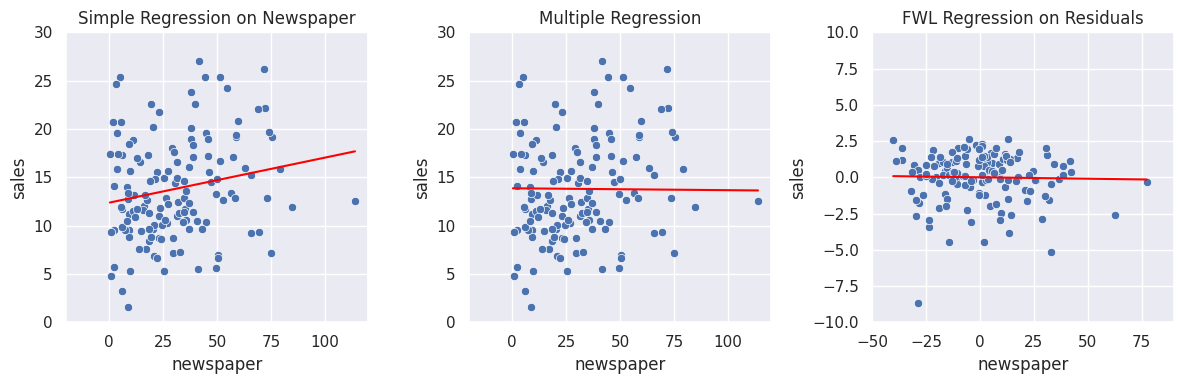

In [38]:

plt.figure(figsize=(12, 4));

plt.subplot(1, 3, 1);
sns.scatterplot(data=train, x="newspaper", y="sales");
sns.lineplot(data=train, x="newspaper", y=reg_news.predict(train[['newspaper']]), color='red');
plt.ylim(0, 30);
plt.xlim(-20, 120);
plt.title("Simple Regression on Newspaper");

plt.subplot(1, 3, 2);
sns.scatterplot(data=train, x="newspaper", y="sales");
sns.lineplot(data=train, x="newspaper", y=train['sales'].mean() - (reg_multi.coef_[2] * train['newspaper'].mean()) + reg_multi.coef_[2] * train['newspaper'], color='red');
plt.ylim(0, 30);
plt.xlim(-20, 120);
plt.title("Multiple Regression");

plt.subplot(1, 3, 3);
sns.scatterplot(x=residual_news_x, y=residual_news_y);
sns.lineplot(x=residual_news_x, y=reg_news_fwl.predict(pd.DataFrame(residual_news_x)), color='red');
plt.title("FWL Regression on Residuals");
plt.ylim(-10, 10);
plt.xlim(-50, 90);

plt.tight_layout();
plt.show();

**Comment on the results**. Compare `residual_news_fwl` (the residual of the “residualized” model) to the residual of the multiple regression model trained in the earlier section - what do you notice, and how do you explain this?

Simple Regression:

Shows a weak positive relationship between newspaper and sales, ignoring TV and radio.

Multiple Regression:

The relationship between newspaper and sales is nearly flat, as TV and radio explain most of the variation.

FWL Regression:

Matches the multiple regression slope for newspaper, isolating its unique contribution after removing TV and radio effects.

Residuals Comparison:

FWL residuals and multiple regression residuals are consistent, confirming the FWL regression isolates the same unique effect of newspaper as the multiple regression.

### 5. Linear regression with interaction terms

Finally, we will try to improve our regression by addressing patterns noted in the residuals of the multiple regression model.

Our multiple linear regression includes additive effects of all three types of advertising media. However, it does not include *interaction* effects, in which combining different types of advertising media together results in a bigger boost in sales than just the additive effect of the individual media.

#### Add interaction terms to the data

The pattern in the residuals plots from parts (1) through (3) suggest that a model including an interaction effect may explain sales data better than a model including additive effects. Add four columns to each data frame (`train` and `test`):

-   `newspaper` $\times$ `radio` (name this column `newspaper_radio`)
-   `TV` $\times$ `radio` (name this column `TV_radio`)
-   `newspaper` $\times$ `TV` (name this column `newspaper_TV`)
-   `newspaper` $\times$ `radio` $\times$ `TV` (name this column `newspaper_radio_TV`)

Note: you can use the `assign` function in `pandas` ([documentation here](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.assign.html)) to create a new column and assign a value to it using operations on other columns.

In [39]:
#grade (write your code in this cell and DO NOT DELETE THIS LINE)
train = train.assign(
    newspaper_radio=train["newspaper"] * train["radio"],
    TV_radio=train["TV"] * train["radio"],
    newspaper_TV=train["newspaper"] * train["TV"],
    newspaper_radio_TV=train["newspaper"] * train["radio"] * train["TV"]
)

In [40]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 140 entries, 134 to 127
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   TV                  140 non-null    float64
 1   radio               140 non-null    float64
 2   newspaper           140 non-null    float64
 3   sales               140 non-null    float64
 4   newspaper_radio     140 non-null    float64
 5   TV_radio            140 non-null    float64
 6   newspaper_TV        140 non-null    float64
 7   newspaper_radio_TV  140 non-null    float64
dtypes: float64(8)
memory usage: 13.9 KB


In [41]:
#grade (write your code in this cell and DO NOT DELETE THIS LINE)
test = test.assign(
    newspaper_radio=test["newspaper"] * test["radio"],
    TV_radio=test["TV"] * test["radio"],
    newspaper_TV=test["newspaper"] * test["TV"],
    newspaper_radio_TV=test["newspaper"] * test["radio"] * test["TV"]
)

In [42]:
test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 60 entries, 85 to 7
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   TV                  60 non-null     float64
 1   radio               60 non-null     float64
 2   newspaper           60 non-null     float64
 3   sales               60 non-null     float64
 4   newspaper_radio     60 non-null     float64
 5   TV_radio            60 non-null     float64
 6   newspaper_TV        60 non-null     float64
 7   newspaper_radio_TV  60 non-null     float64
dtypes: float64(8)
memory usage: 4.2 KB


#### Fit a multiple linear regression with interaction terms

Then, train a linear regression model on all seven features: the three types of ad budgets, and the four interaction effects.

In [43]:
#grade (write your code in this cell and DO NOT DELETE THIS LINE)

# reg_inter = ....

features = ["newspaper", "radio", "TV", "newspaper_radio", "TV_radio", "newspaper_TV", "newspaper_radio_TV"]

# Train the linear regression model using the train dataset
reg_inter = LinearRegression()
reg_inter.fit(train[features], train["sales"])

LinearRegression()

#### Compute R2, MSE for multiple regression with interaction terms

Then, let’s get:

-   the predictions on the training set: `y_pred_tr_inter`
-   the R2 score on the training set: `r2_tr_inter`
-   the MSE on the training set: `mse_tr_inter`

In [44]:
#grade (write your code in this cell and DO NOT DELETE THIS LINE)

# y_pred_tr_inter = ...
# r2_tr_inter  = ...
# mse_tr_inter = ...

y_pred_tr_inter = reg_inter.predict(train[features])

# Compute R2 and MSE for the training set
r2_tr_inter = r2_score(train["sales"], y_pred_tr_inter)
mse_tr_inter = mean_squared_error(train["sales"], y_pred_tr_inter)

In [45]:
# print("Multiple regression with interaction R2:  ", r2_tr_inter)
# print("Multiple regression with interaction MSE: ", mse_tr_inter)

print("Multiple regression with interaction R2:  ", r2_tr_inter)
print("Multiple regression with interaction MSE: ", mse_tr_inter)


Multiple regression with interaction R2:   0.9639737928022052
Multiple regression with interaction MSE:  0.9979102054843437


#### Compute residuals

Compute the residuals ($y - \hat{y}$).

In [46]:
#grade (write your code in this cell and DO NOT DELETE THIS LINE)

# residual_inter_tr = ...
residual_inter_tr = train["sales"] - y_pred_tr_inter

#### Plot predicted vs. actual sales

Next, plot predicted sales vs. actual sales for the multiple regression model with interaction terms.

-   Create a scatter plot of predicted sales ($\hat{y}$) on the vertical axis, and actual sales ($y$) on the horizontal axis.
-   Make sure both axes use the same scale (the range of the vertical axis should be the same as the range of the horizontal axis).
-   Label each axes.

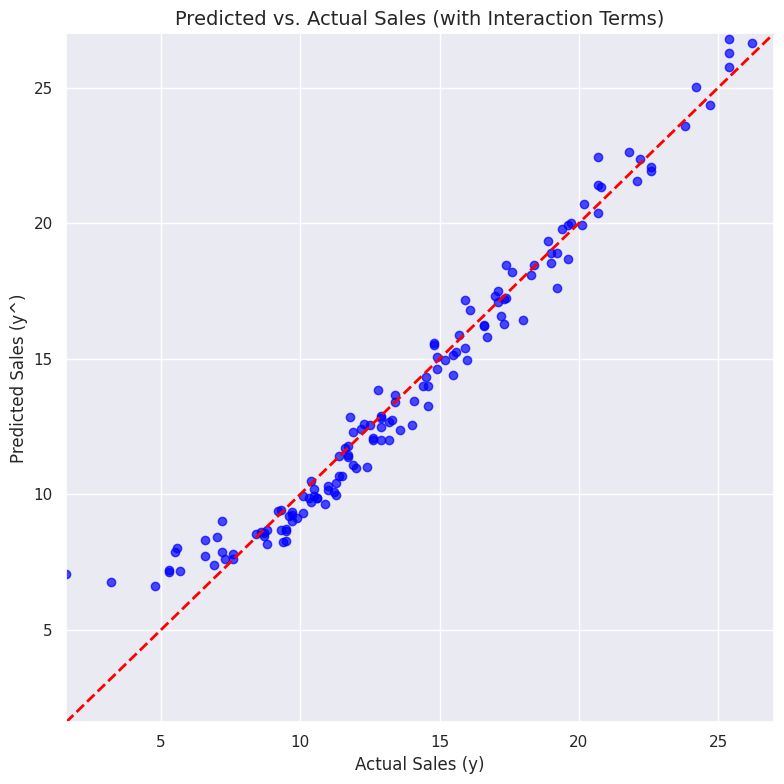

In [47]:
# plot

# Plot predicted sales vs. actual sales
plt.figure(figsize=(8, 8))
plt.scatter(train["sales"], y_pred_tr_inter, alpha=0.7, color="blue")

# Add a diagonal line
plt.plot([train["sales"].min(), train["sales"].max()],
         [train["sales"].min(), train["sales"].max()],
         color="red", linestyle="--", linewidth=2)

# Set the labels and title
plt.xlabel("Actual Sales (y)", fontsize=12)
plt.ylabel("Predicted Sales (y^)", fontsize=12)
plt.title("Predicted vs. Actual Sales (with Interaction Terms)", fontsize=14)

plt.xlim(train["sales"].min(), train["sales"].max())
plt.ylim(train["sales"].min(), train["sales"].max())

# Show the plot
plt.grid(True)
plt.tight_layout()
plt.show()

**Comment on this plot**. What would you expect this plot to look like for a model that explains the data well? What does the plot tell you about your model in this specific case? In particular, compare what you observe here to your observations from the similar plot on the multiple regression model without interaction terms.

The plot shows that the predicted sales closely align with the actual sales, indicating the model with interaction terms explains the data well. Most points cluster around the red diagonal line, with minimal scatter, suggesting small residuals. Compared to the model without interaction terms, this model captures the relationships more effectively, especially for higher and lower sales values. Overall, adding interaction terms significantly improves the model's fit.

#### Plot residuals vs. actual sales

Next, create a plot of residuals vs. actual sales for the multiple regression model with interaction terms.

-   Create a scatter plot with the residuals ($y - \hat{y}$) on the vertical axis, and actual sales ($y$) on the horizontal axis.
-   Label each axes, and each plot.

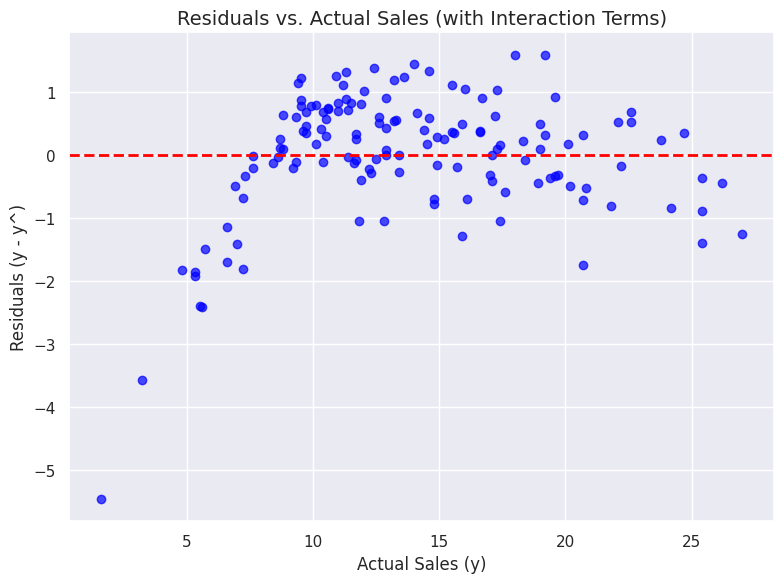

In [48]:
# plot
plt.figure(figsize=(8, 6))
plt.scatter(train["sales"], residual_inter_tr, alpha=0.7, color="blue")

# Add a horizontal line at y = 0
plt.axhline(y=0, color='red', linestyle='--', linewidth=2)

# Set the labels and title
plt.xlabel("Actual Sales (y)", fontsize=12)
plt.ylabel("Residuals (y - y^)", fontsize=12)
plt.title("Residuals vs. Actual Sales (with Interaction Terms)", fontsize=14)

# Show the plot
plt.grid(True)
plt.tight_layout()
plt.show()

**Comment on this plot**. Is there a pattern in the residuals (and if so, what might it indicate), or do they appear to have no pattern with respect to actual sales? In particular, compare what you observe here to your observations from the similar plot on the multiple regression model without interaction terms.

The residuals are randomly scattered around the red line, indicating no clear pattern and a good fit for the model with interaction terms. Compared to the model without interaction terms, this plot shows reduced structure in the residuals, suggesting the interaction terms improve the model’s accuracy. However, a few outliers remain, indicating room for further refinement.

#### Plot residuals vs. features

Finally, you’ll create a plot of residuals vs. features, for each of the three **original** features (not the interaction terms), for your multiple regression model with interaction terms. Put your three subplots in one row.

In each subplot,

-   create a scatter plot with the residuals ($y - \hat{y}$) on the vertical axis, and the feature ($x$) on the horizontal axis.
-   Use the same vertical scale for all subplots (but the horizontal scale will depend on the feature! The upper end of the TV ad spending range is different from the radio ad spending range.)
-   Make sure to clearly label each axis, and also label each subplot with a title that indicates which regression model it uses.

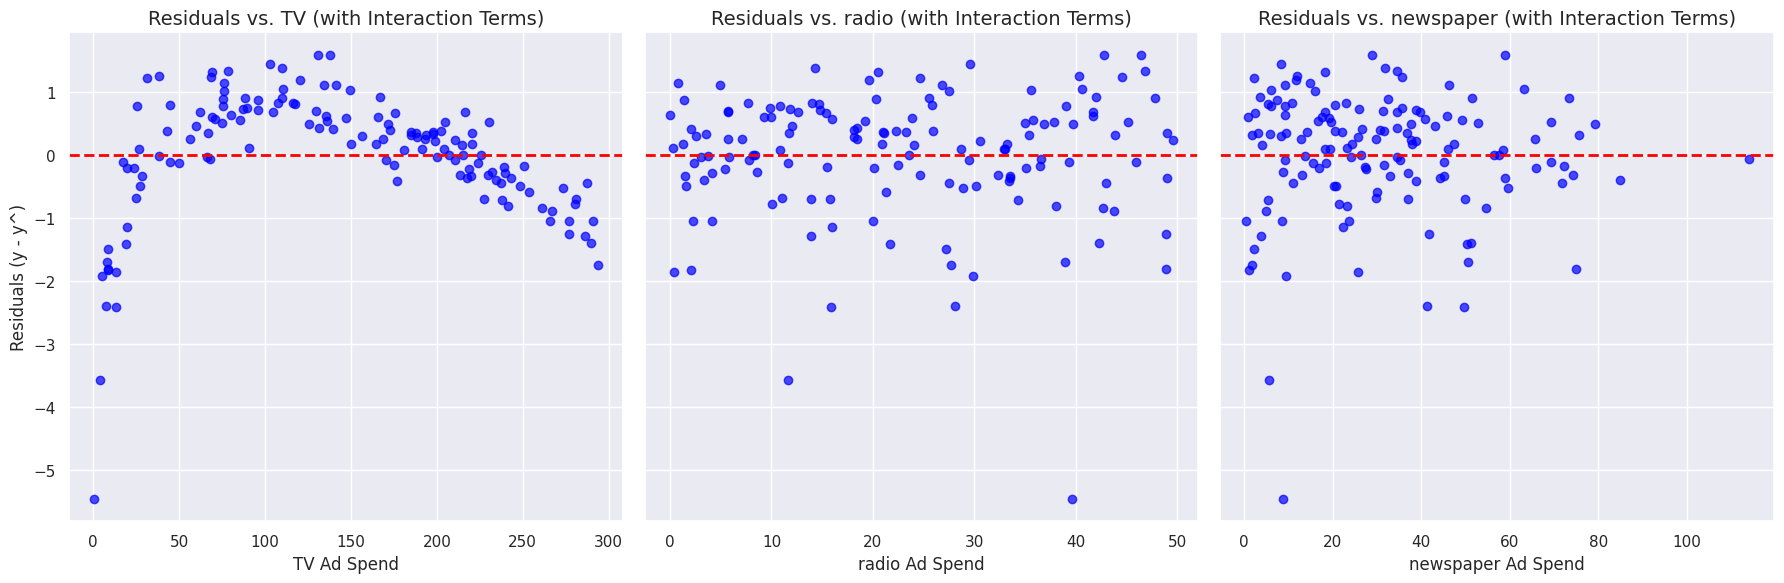

In [49]:
# plot
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)


features = ['TV', 'radio', 'newspaper']

for i, feature in enumerate(features):
    axes[i].scatter(train[feature], residual_inter_tr, alpha=0.7, color="blue")
    axes[i].axhline(y=0, color='red', linestyle='--', linewidth=2)  #add the line
    axes[i].set_xlabel(f"{feature} Ad Spend", fontsize=12)
    axes[i].set_title(f"Residuals vs. {feature} (with Interaction Terms)", fontsize=14)  # set the title

axes[0].set_ylabel("Residuals (y - y^)", fontsize=12)

plt.tight_layout()
plt.show()

**Comment on this plot**. Is there a pattern in the residuals (and if so, what might it indicate), or do they appear to have no pattern with respect to each of the three features? In particular, compare what you observe here to your observations from the similar plot on the multiple regression model without interaction terms.

For TV, residuals show a slight curve, suggesting a possible non-linear relationship. For radio, residuals are randomly scattered, indicating a good fit. For newspaper, some clustering at lower spending suggests inconsistencies. Compared to the model without interaction terms, residual patterns have improved, though TV still shows room for refinement.

#### Compute test R2, MSE for multiple regression with interaction terms

Finally, use this fitted model to get:

-   the predictions on the **test** set: `y_pred_ts_inter`
-   the R2 score on the **test** set: `r2_ts_inter`
-   the MSE on the \*\*test\* set: `mse_ts_inter`

In [61]:
#grade (write your code in this cell and DO NOT DELETE THIS LINE)

# y_pred_ts_inter = ...
# r2_ts_inter  = ...
# mse_ts_inter = ...

# Compute predictions on the test set
y_pred_ts_inter = reg_inter.predict(test[features])  # Use the fitted model to predict on the test set

# Compute R2 score and MSE on the test set
r2_ts_inter = r2_score(test["sales"], y_pred_ts_inter)  # R2 score
mse_ts_inter = mean_squared_error(test["sales"], y_pred_ts_inter)

In [60]:
# print("Multiple regression with interaction R2 - test set:  ", r2_ts_inter)
# print("Multiple regression with interaction MSE- test set: ", mse_ts_inter)

print("Multiple regression with interaction R2 - test set:  ", r2_ts_inter)
print("Multiple regression with interaction MSE - test set: ", mse_ts_inter)


Multiple regression with interaction R2 - test set:   0.9782903463061292
Multiple regression with interaction MSE - test set:  0.548782596228433
